# Business Analysis

## User Satisfaction Analysis

### Importing necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import mlflow
import mlflow.sklearn
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
import warnings
warnings.filterwarnings('ignore', category= pd.errors.SettingWithCopyWarning)

In [3]:
import os
import sys

sys.path.append((os.path.abspath('../scripts')))

from Utils import *
from Overview_analyzer import *
from Satisfaction_analyzer import *

DbConn = DatabaseConn()


#### Loading data from database

In [4]:
data = DbConn.load_data_from_database()

In [5]:
data_utils = DataUtils(data)
data = data_utils.data_cleaning()

>>>>>>> The data has been cleaned and outliers removed. 
The number of null values in your data are 0


In [6]:
overview_analyzer = OverviewAnalyzer(data)

In [7]:
user_behaviour_MSISDN = overview_analyzer.user_behaviour_Id('MSISDN/Number', data)
# To remove unknow Id
user_behaviour_MSISDN = user_behaviour_MSISDN.iloc[1:]


### Engagement Score

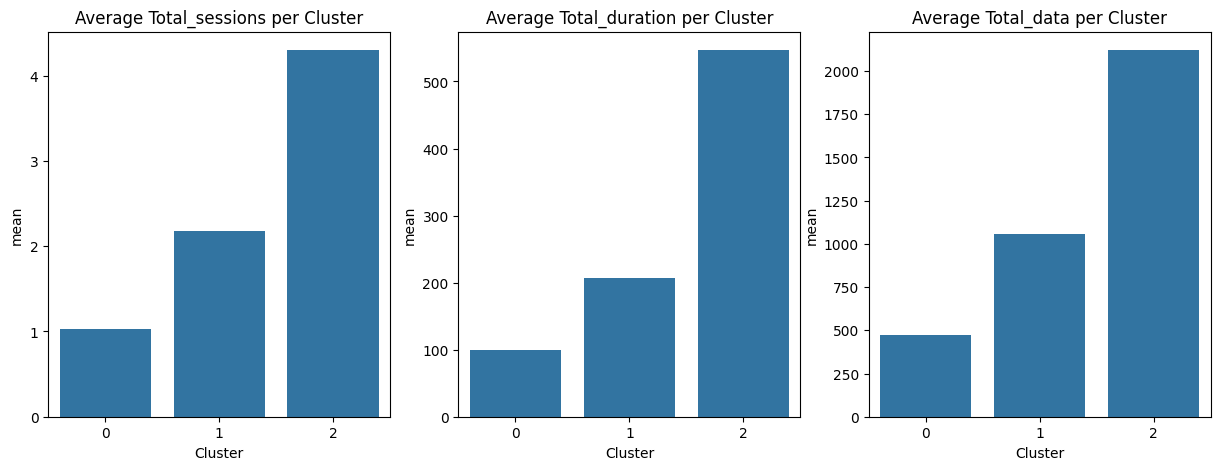

In [8]:
cols = ['Total_sessions', 'Total_duration', 'Total_data']
satisfacion = SatAnalyzer(cols, user_behaviour_MSISDN, n_clusters= 3)
data_with_score =satisfacion.score_calculator(True)

### Experience Score

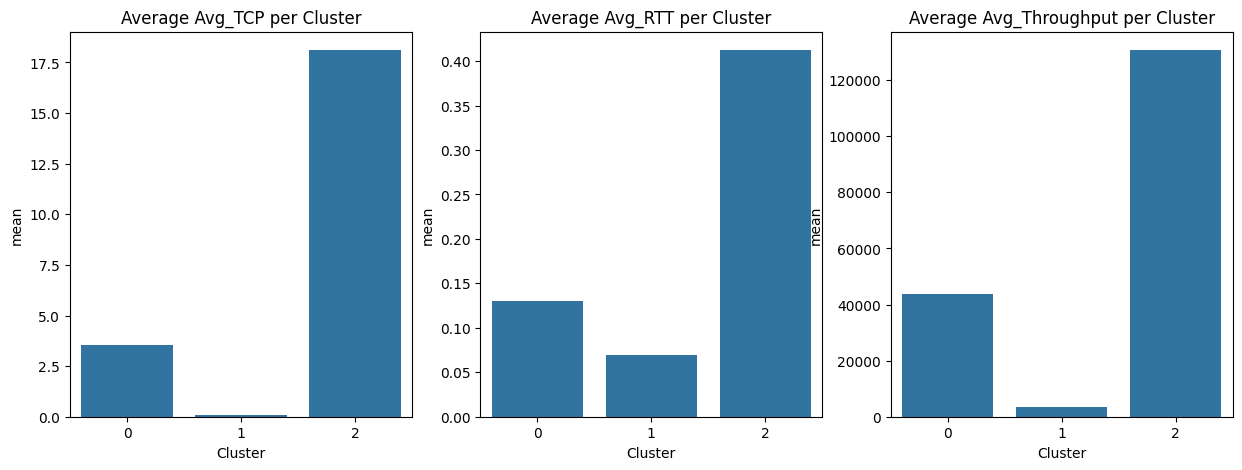

In [9]:
cols = ['Avg_TCP', 'Avg_RTT', 'Avg_Throughput']
satisfacion = SatAnalyzer(cols, user_behaviour_MSISDN, n_clusters= 3)
data_with_score = satisfacion.score_calculator(False)

#### Satisfaction score

In [10]:
data_with_score['Sataisfacion_Score'] = (data_with_score['Engagement_Score'] + data_with_score['Experience_Score']) /2 

In [11]:
cols = ['Engagement_Score', 'Experience_Score', 'Sataisfacion_Score']
scores = data_with_score[cols]
scores.sort_values(by='Sataisfacion_Score', ascending=False, inplace=True)

#### Top ten satisfied customers

In [12]:
scores.head(10)

,Engagement_Score,Experience_Score,Sataisfacion_Score
MSISDN/Number,,,
3.376233e+10,5132.063048,439504.212582,222318.137815
3.365955e+10,4887.968653,415185.713164,210036.840908
3.361489e+10,9293.756786,373221.962575,191257.859680
3.365936e+10,5041.453004,359983.712748,182512.582876
3.366278e+10,3153.288632,327369.962640,165261.625636
3.360452e+10,5925.804324,318225.841167,162075.822745
3.365826e+10,5708.763291,313341.837622,159525.300457
3.369925e+10,3616.220431,311650.342145,157633.281288
3.369933e+10,2010.717502,311085.838858,156548.278180


### Regression model

In [13]:
features = ['Total_sessions', 'Total_duration', 'Total_data', 
       'Social_media', 'YouTube', 'Netflix', 'Google', 'Email', 'Gaming','Other', 
       'Avg_TCP', 'Avg_RTT',  'Avg_Throughput',
        'Engagement_Score', 'Experience_Score', 'Sataisfacion_Score']

data_for_model = data_with_score[features]

##### Looking for correlations

In [14]:
num_attrib = data_for_model.select_dtypes(exclude='object').columns

corr_matrix = data_for_model[num_attrib].corr()
corr_matrix['Sataisfacion_Score']


Total_sessions        0.580065
Total_duration        0.293616
Total_data            0.474977
Social_media          0.445582
YouTube               0.497364
Netflix               0.499227
Google                0.485061
Email                 0.475880
Gaming                0.451088
Other                 0.450874
Avg_TCP               0.665990
Avg_RTT               0.654878
Avg_Throughput        0.999903
Engagement_Score      0.474186
Experience_Score      0.999903
Sataisfacion_Score    1.000000
Name: Sataisfacion_Score, dtype: float64

**Observation**
- From the above we can see that satisfaction score is highly correlated with Experience_Score and Avg_Throughput which makes sence since Avg_Throughput is the amount of data that has been successfully transmitted

##### Data cleaning

In [15]:
# Features and target
X = data_for_model.drop('Sataisfacion_Score', axis = 1)
y = data_for_model['Sataisfacion_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

In [16]:
num_attrib = X_train.select_dtypes(exclude='object').columns

processor = ColumnTransformer(transformers=[
    ('scale', StandardScaler(), num_attrib)
])


model_pipeline = Pipeline([
    ('processor', processor),
    ('regressor', model)
])



In [17]:
with mlflow.start_run() as run:

    model_pipeline.fit(X_train, y_train)
    
    y_pred = model_pipeline.predict(X_test)
    
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
    print(f"Root Mean Squared Error: {rmse}")

    mlflow.sklearn.log_model(model_pipeline, "model")

    mlflow.log_metric("rmse", rmse)

    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    
    print(f"MLflow Run ID: {run.info.run_id}")
    print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

Root Mean Squared Error: 9.494128307811434e-06


2024/09/10 22:39:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Run ID: 0307dcbe0e0a42968f80d3647fb3840f
MLflow Tracking URI: file:///c:/Users/user/Documents/Programming/Kifiya_10X/Business_Analysis/notebooks/mlruns


**Observation**
- High model accuracy

##### Clustering

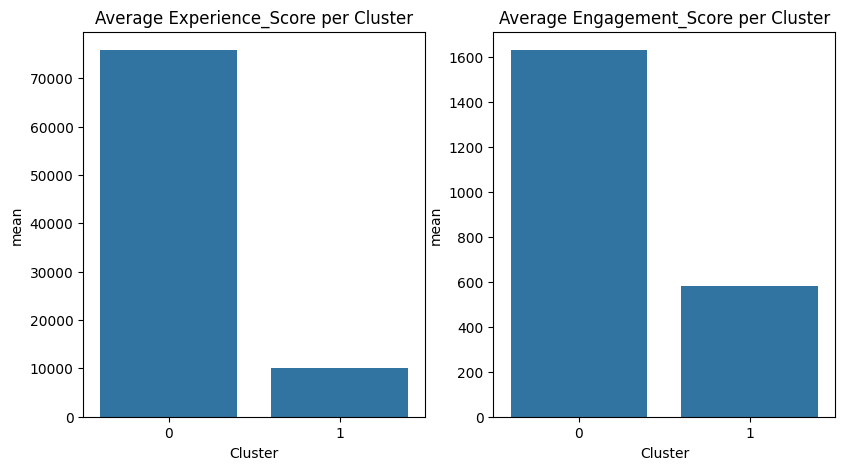

In [19]:
cols = ['Experience_Score', 'Engagement_Score']
data_with_cluster, cluster_stats, kmeans = data_utils.cluster_analysis(cols, data_for_model, 2)

In [20]:
data_with_cluster.groupby(by='Cluster')[['Sataisfacion_Score', 'Experience_Score']].sum()

,Sataisfacion_Score,Experience_Score
Cluster,,
0,3.974763e+08,7.782139e+08
1,5.177770e+08,9.793858e+08


In [21]:
cols = ['Engagement_Score', 'Experience_Score', 'Sataisfacion_Score']
final_scores = data_with_cluster[cols]
final_scores.head()

,Engagement_Score,Experience_Score,Sataisfacion_Score
MSISDN/Number,,,
3.362632e+10,8592.714947,121344.087565,64968.401256
3.362578e+10,9100.279018,188311.962564,98706.120791
3.361489e+10,9293.756786,373221.962575,191257.859680
3.365973e+10,8136.264996,229803.837565,118970.051281
3.376054e+10,8801.857762,134967.463964,71884.660863


In [24]:
DbConn.save_to_database(final_scores)